# JFK Fligths - Delay Prediction

## 0. Description

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. 

You have been recently hired as a Data Scientist by the DOT to help them mitigate the consequences of delayed flights. Our assignment is the development of a machine learning model that allows to predict the probability of a flight been delayed. 

As a first exercise, we are implementing a **model to predict whether a flight will have a delay higher than 15 minutes.** The data available contains all relevant information for flights arriving to JFK airport (NYC). This is the data that we will use to build a first pilot version of the model. If this model is proven effective, our model will be extended to incorporate all airports at a national level.  

## 1. Libraries

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import __version__ as sklearn_version

In [4]:
print('The scikit-learn version is {}.'.format(sklearn_version))

The scikit-learn version is 1.2.1.


## 2. Importing data

Before starting with our ML Checklist, the first stage is to import the data for this project (JFKFlights). This dataset is available in the official website for the US Bureau of Transportation Statistics, but we'll directly download it from a public repository in GitHub. The dataset is split in two files because of size limitations from Github. We'll have to import them independently and merge them. 

In [5]:
url1 = 'https://bit.ly/3jAxEwk'
url2 = 'https://bit.ly/3t8qJOf'

In [6]:
df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)

In [8]:
df=pd.concat([df1,df2],axis=0)

## 3. Data understanding

### `3.1. First impressions`

In [9]:
df.head()

,Unnamed: 0,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,TAXI_OUT,CRS_ARR_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE
0,0,2018-02-01,20363.0,N299PQ,BNA,"Nashville, TN",Tennessee,JFK,"New York, NY",New York,1359,27.0,1719,0.0,140.0,765.0
1,1,2018-02-01,20363.0,N920XJ,RDU,"Raleigh/Durham, NC",North Carolina,JFK,"New York, NY",New York,1354,37.0,1541,0.0,107.0,427.0
2,2,2018-02-01,20363.0,N605LR,BUF,"Buffalo, NY",New York,JFK,"New York, NY",New York,1529,21.0,1709,0.0,100.0,301.0
3,3,2018-02-01,20363.0,N800AY,ORF,"Norfolk, VA",Virginia,JFK,"New York, NY",New York,1704,36.0,1845,0.0,101.0,290.0
4,4,2018-02-01,20363.0,N600LR,BOS,"Boston, MA",Massachusetts,JFK,"New York, NY",New York,1325,20.0,1454,0.0,89.0,187.0


In [11]:
df.shape

(250152, 16)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250152 entries, 0 to 150151
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             250152 non-null  int64  
 1   FL_DATE                250152 non-null  object 
 2   OP_CARRIER_AIRLINE_ID  237644 non-null  float64
 3   TAIL_NUM               235143 non-null  object 
 4   ORIGIN                 250152 non-null  object 
 5   ORIGIN_CITY_NAME       250152 non-null  object 
 6   ORIGIN_STATE_NM        250152 non-null  object 
 7   DEST                   250152 non-null  object 
 8   DEST_CITY_NAME         250152 non-null  object 
 9   DEST_STATE_NM          250152 non-null  object 
 10  CRS_DEP_TIME           250152 non-null  int64  
 11  TAXI_OUT               232641 non-null  float64
 12  CRS_ARR_TIME           250152 non-null  int64  
 13  ARR_DEL15              250152 non-null  float64
 14  CRS_ELAPSED_TIME       250152 non-nu

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,250152.0,125075.500000,72212.806607,0.0,62537.75,125075.5,187613.25,250151.0
OP_CARRIER_AIRLINE_ID,237644.0,20152.000736,297.881929,19690.0,19790.00,20363.0,20409.00,21171.0
CRS_DEP_TIME,250152.0,1334.611164,529.100385,3.0,915.00,1258.0,1744.00,2359.0
TAXI_OUT,232641.0,18.189820,9.609596,1.0,12.00,16.0,21.00,166.0
CRS_ARR_TIME,250152.0,1419.131404,580.986009,1.0,944.00,1455.0,1914.00,2400.0
ARR_DEL15,250152.0,0.210400,0.407594,0.0,0.00,0.0,0.00,1.0
CRS_ELAPSED_TIME,250152.0,195.647706,97.374339,47.0,109.00,167.0,306.00,595.0
DISTANCE,250152.0,1258.844866,898.116163,94.0,427.00,1028.0,2248.00,4983.0


Here is the available information explaining each variable in the dataset:

* **FL_DATE**: Date of the observation
* **OP_CARRIER_AIRLINE_ID**: IAn identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.
* **TAIL_NUM**: Tail Number, unique identifier for the plane
* **ORIGIN**: origin airport
* **ORIGIN_CITY_NAME**: origin airport
* **ORIGIN_STATE_NM**: origin state (USA)
* **DEST**: destination airport (JFK for all registers)
* **DEST_CITY_NAME**: destination city (NYC for all registers)
* **DEST_STATE_NM**: destination state (NY for all registers)
* **CRS_DEP_TIME**: scheduled departure time
* **TAXI_OUT**: run away time (time between exit from terminal and take-off) 
* **CRS_ARR_TIME**: scheduled arrival time
* **ARR_DEL15**: boolean (1/0) indicating if there has been more than 15 minutes delay
* **CRS_ELAPSED_TIME**: expected flight duration
* **DISTANCE**: distance between airports

We are working on a classification problem, and our target will be the variable **ARR_DEL15**.

In [17]:
df.columns=df.columns.str.lower()
df.columns

Index(['unnamed: 0', 'fl_date', 'op_carrier_airline_id', 'tail_num', 'origin',
       'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name',
       'dest_state_nm', 'crs_dep_time', 'taxi_out', 'crs_arr_time',
       'arr_del15', 'crs_elapsed_time', 'distance'],
      dtype='object')

In [19]:
target="arr_del15"

### `3.2. Feature variety`

We have observed there are both numerical and categorical features.

In [20]:
df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
fl_date,250152,730,2018-07-19,394
tail_num,235143,2645,N110AN,761
origin,250152,72,LAX,25345
origin_city_name,250152,70,"Los Angeles, CA",25345
origin_state_nm,250152,32,California,51137
dest,250152,1,JFK,250152
dest_city_name,250152,1,"New York, NY",250152
dest_state_nm,250152,1,New York,250152


Knowing there is always the same destiny (JFK Airport, New York) we are going to remove the columns related to it.

In [21]:
df.drop(columns=["dest","dest_city_name","dest_state_nm"],inplace=True)
df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
fl_date,250152,730,2018-07-19,394
tail_num,235143,2645,N110AN,761
origin,250152,72,LAX,25345
origin_city_name,250152,70,"Los Angeles, CA",25345
origin_state_nm,250152,32,California,51137


In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
unnamed: 0,250152.0,125075.500000,72212.806607,0.0,62537.75,125075.5,187613.25,250151.0
op_carrier_airline_id,237644.0,20152.000736,297.881929,19690.0,19790.00,20363.0,20409.00,21171.0
crs_dep_time,250152.0,1334.611164,529.100385,3.0,915.00,1258.0,1744.00,2359.0
taxi_out,232641.0,18.189820,9.609596,1.0,12.00,16.0,21.00,166.0
crs_arr_time,250152.0,1419.131404,580.986009,1.0,944.00,1455.0,1914.00,2400.0
arr_del15,250152.0,0.210400,0.407594,0.0,0.00,0.0,0.00,1.0
crs_elapsed_time,250152.0,195.647706,97.374339,47.0,109.00,167.0,306.00,595.0
distance,250152.0,1258.844866,898.116163,94.0,427.00,1028.0,2248.00,4983.0


Let's see how balanced the problem is

<Axes: >

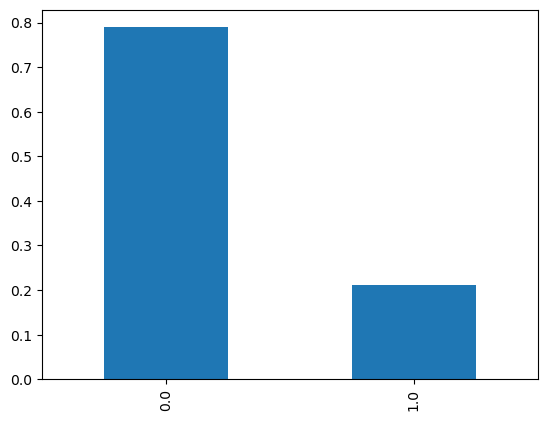

In [27]:
df[target].value_counts(normalize=True).plot(kind="bar")

Even though the delayed flighs are the 20% aproximately, we can consider the problem as a balanced one.

### `3.3. Nulls`

In [29]:
df.isna().sum()

unnamed: 0                   0
fl_date                      0
op_carrier_airline_id    12508
tail_num                 15009
origin                       0
origin_city_name             0
origin_state_nm              0
crs_dep_time                 0
taxi_out                 17511
crs_arr_time                 0
arr_del15                    0
crs_elapsed_time             0
distance                     0
dtype: int64

#### 3.3.1. op_carrier_airline_id

* **OP_CARRIER_AIRLINE_ID**: IAn identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.

In [31]:
df.op_carrier_airline_id.value_counts(dropna=False)

20409.0    78587
19790.0    58894
20363.0    40833
19805.0    30694
NaN        12508
20398.0     8814
19930.0     8591
20452.0     5044
20304.0     3993
21171.0      944
19690.0      695
20397.0      555
Name: op_carrier_airline_id, dtype: int64

We can not manage to study the feature much deeper because it is an id. A solution may be changing the nulls into whatever in order to do later the encoding.

In [32]:
df.op_carrier_airline_id.fillna("NaN",inplace=True)
df.isna().sum()

unnamed: 0                   0
fl_date                      0
op_carrier_airline_id        0
tail_num                 15009
origin                       0
origin_city_name             0
origin_state_nm              0
crs_dep_time                 0
taxi_out                 17511
crs_arr_time                 0
arr_del15                    0
crs_elapsed_time             0
distance                     0
dtype: int64

#### 3.3.2. tail_num

* **TAIL_NUM**: Tail Number, unique identifier for the plane

In [33]:
df.tail_num.value_counts(dropna=False)

NaN       15009
N110AN      761
N113AN      751
N111ZM      748
N115NN      740
          ...  
N197UW        1
N986AN        1
N315RJ        1
N801AW        1
N945DN        1
Name: tail_num, Length: 2646, dtype: int64

Same as before

In [34]:
df.tail_num.fillna("NaN",inplace=True)
df.isna().sum()

unnamed: 0                   0
fl_date                      0
op_carrier_airline_id        0
tail_num                     0
origin                       0
origin_city_name             0
origin_state_nm              0
crs_dep_time                 0
taxi_out                 17511
crs_arr_time                 0
arr_del15                    0
crs_elapsed_time             0
distance                     0
dtype: int64

#### 3.3.3. taxi_out

* **TAXI_OUT**: run away time (time between exit from terminal and take-off) 

In [35]:
df.taxi_out.value_counts(dropna=False)

13.0     18840
12.0     18344
14.0     18119
NaN      17511
15.0     16614
         ...  
146.0        1
161.0        1
159.0        1
140.0        1
156.0        1
Name: taxi_out, Length: 155, dtype: int64

Let's replace them with the value -1.

In [36]:
df.taxi_out.fillna(-1,inplace=True)
df.isna().sum()

unnamed: 0               0
fl_date                  0
op_carrier_airline_id    0
tail_num                 0
origin                   0
origin_city_name         0
origin_state_nm          0
crs_dep_time             0
taxi_out                 0
crs_arr_time             0
arr_del15                0
crs_elapsed_time         0
distance                 0
dtype: int64

### `3.4. More data cleaning`

In [39]:
df['unnamed: 0'].value_counts(dropna=False)

0         1
166758    1
166760    1
166761    1
166762    1
         ..
83388     1
83389     1
83390     1
83391     1
250151    1
Name: unnamed: 0, Length: 250152, dtype: int64

We can consider this feature as an id, so we can remove it aswell

In [40]:
df.drop(columns=["unnamed: 0"],inplace=True)